In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data sources (World Bank via pandas_datareader)
from pandas_datareader import data, wb  # Correctly import 'wb' for World Bank specific functions

# Time series tools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Optional: XGBoost
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

# Optional: Prophet (if installed)
try:
    from prophet import Prophet
    has_prophet = True
except Exception:
    has_prophet = False

# Display options
pd.set_option('display.max_columns', 200)
%matplotlib inline

print('Libraries loaded')

Libraries loaded


## Data sources and download

**Primary target (y):** Gini index (World Bank indicator code: `SI.POV.GINI`) — Gini coefficient, 0-100.

**Candidate predictors (X):** Selected World Bank indicators available per-country per-year:

- `NY.GDP.PCAP.KD` — GDP per capita (constant USD)
- `SL.UEM.TOTL.ZS` — Unemployment (% of labor force)
- `FP.CPI.TOTL.ZG` — Inflation (annual %)
- `SE.XPD.TOTL.GD.ZS` — Government expenditure on education (% of GDP)
- `NE.TRD.GNFS.ZS` — Trade (% of GDP)
- `SP.POP.TOTL` — Population (simple control)

We'll download these from the World Bank for a list of countries and years.


In [2]:
# Parameters
countries = ['USA','IND','CHN','BRA','ZAF','GBR','DEU']  # ISO3 codes accepted by World Bank API
start_year = 1990
end_year = 2022

# Indicators dictionary
indicators = {
    'SI.POV.GINI': 'gini',
    'NY.GDP.PCAP.KD': 'gdp_percap_const',
    'SL.UEM.TOTL.ZS': 'unemployment_pct',
    'FP.CPI.TOTL.ZG': 'inflation_pct',
    'SE.XPD.TOTL.GD.ZS': 'edu_spend_pct_gdp',
    'NE.TRD.GNFS.ZS': 'trade_pct_gdp',
    'SP.POP.TOTL': 'population'
}

from functools import reduce
frames = []
for code, name in indicators.items():
    print('Downloading', code)
    try:
        # Use wb.download, which is more robust for World Bank data and accepts 'country'
        df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)
        df = df.reset_index() # country and year become columns

        # Rename columns: the indicator code to its friendly name, and 'country' to 'country_name'
        df = df.rename(columns={'country': 'country_name', code: name})

        frames.append(df[['country_name','year', name]])
    except Exception as e:
        print('Failed to fetch', code, ' — ', e)

if frames:
    data = reduce(lambda left, right: pd.merge(left, right, on=['country_name','year'], how='outer'), frames)
else:
    raise RuntimeError('No data frames fetched. Please download CSVs manually.')

data.sort_values(['country_name','year'], inplace=True)
data.head()

/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)
/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)


/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)


/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)


/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)


/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)
/tmp/ipython-input-1856963155.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)


,country_name,year,gini,gdp_percap_const,unemployment_pct,inflation_pct,edu_spend_pct_gdp,trade_pct_gdp,population
0,Brazil,1990,60.5,6149.867889,NaN,2947.732772,NaN,15.155599,149143223
1,Brazil,1991,NaN,6107.648837,6.894,432.786662,NaN,16.592078,151724256
2,Brazil,1992,53.1,5973.982856,7.086,951.962053,NaN,19.253375,154275079
3,Brazil,1993,60.1,6167.460922,6.030,1927.380790,NaN,19.599321,156794577
4,Brazil,1994,NaN,6427.169019,6.578,2075.888398,NaN,18.674760,159265006


## Data cleaning & transformation

We'll clean missing values, create lag features (for time-series models), and convert Gini to numeric. We'll also inspect missingness and decide imputation strategies.


In [4]:
# Convert columns to numeric
for c in ['gini','gdp_percap_const','unemployment_pct','inflation_pct','edu_spend_pct_gdp','trade_pct_gdp','population']:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors='coerce')

# Check missingness
missing_summary = data.isna().mean().sort_values(ascending=False)
print('Missing fraction per column:')
print(missing_summary)

# Drop rows with missing gini (target) for modeling — for EDA we may keep them
data_model = data.dropna(subset=['gini']).copy()

# Simple imputation for predictors: forward-fill per country, then global mean
predictors = ['gdp_percap_const','unemployment_pct','inflation_pct','edu_spend_pct_gdp','trade_pct_gdp','population']

for col in predictors:
    if col in data_model.columns:
        # Use transform instead of apply for group-wise operations that return series of same length
        data_model[col] = data_model.groupby('country_name')[col].transform(lambda x: x.ffill().bfill())
        data_model[col] = data_model[col].fillna(data_model[col].mean())

# Cast year int
data_model['year'] = data_model['year'].astype(int)

print('Data prepared for modeling — rows:', len(data_model))
data_model.head()

Missing fraction per column:
edu_spend_pct_gdp    0.402597
gini                 0.329004
unemployment_pct     0.030303
inflation_pct        0.017316
country_name         0.000000
gdp_percap_const     0.000000
year                 0.000000
trade_pct_gdp        0.000000
population           0.000000
dtype: float64
Data prepared for modeling — rows: 155


,country_name,year,gini,gdp_percap_const,unemployment_pct,inflation_pct,edu_spend_pct_gdp,trade_pct_gdp,population
0,Brazil,1990,60.5,6149.867889,7.086,2947.732772,4.56816,15.155599,149143223
2,Brazil,1992,53.1,5973.982856,7.086,951.962053,4.56816,19.253375,154275079
3,Brazil,1993,60.1,6167.460922,6.030,1927.380790,4.56816,19.599321,156794577
5,Brazil,1995,59.5,6596.335727,7.092,66.007034,4.56816,16.984460,161735073
6,Brazil,1996,59.8,6640.727007,8.035,15.757666,4.56816,15.635591,164202549


## Exploratory Data Analysis (brief)

We'll produce a few plots: Gini over time for selected countries and pairwise correlations.


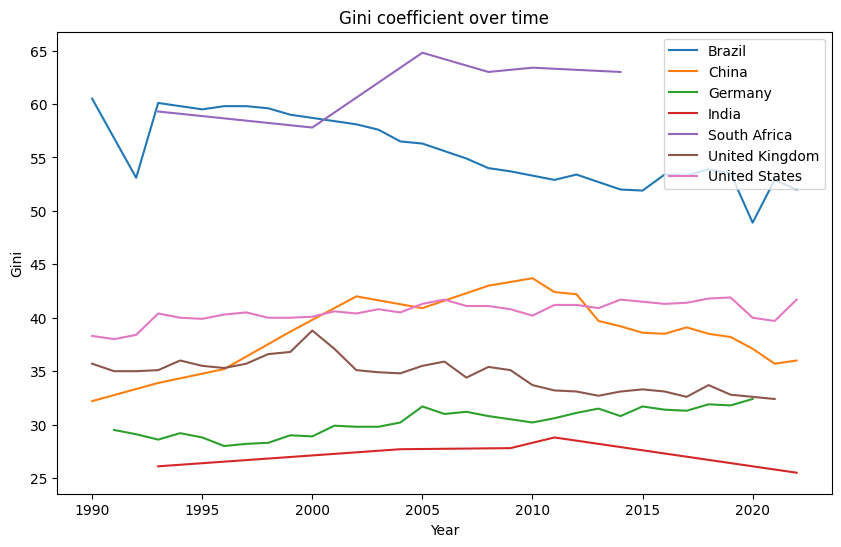

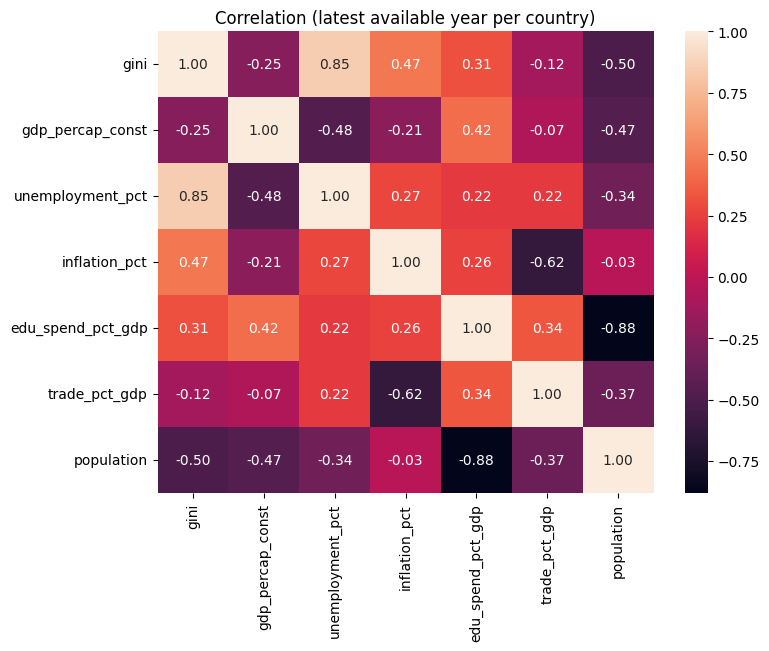

In [5]:
# Plot Gini over time for each country
plt.figure(figsize=(10,6))
for country in data_model['country_name'].unique():
    dfc = data_model[data_model['country_name']==country]
    plt.plot(dfc['year'], dfc['gini'], label=country)
plt.legend()
plt.title('Gini coefficient over time')
plt.xlabel('Year')
plt.ylabel('Gini')
plt.show()

# Correlation heatmap for numeric features (latest year snapshot)
latest = data_model.sort_values('year').groupby('country_name').tail(1)
corr = latest[['gini'] + predictors].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation (latest available year per country)')
plt.show()

## Time-series forecasting (per-country)

Approach: For each country separately, build a simple ARIMA model on past Gini values and forecast next `h` years.


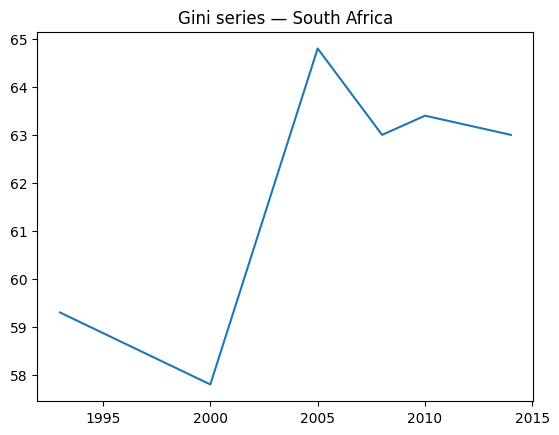

                               SARIMAX Results                                
Dep. Variable:                   gini   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -16.983
Date:                Sun, 07 Dec 2025   AIC                             39.965
Time:                        05:06:17   BIC                             43.099
Sample:                             0   HQIC                            40.645
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5617      0.317      1.769      0.077      -0.061       1.184
ma.L1          0.1671      0.667      0.250      0.802      -1.141       1.475
sigma2         0.2870      0.070      4.122      0.0

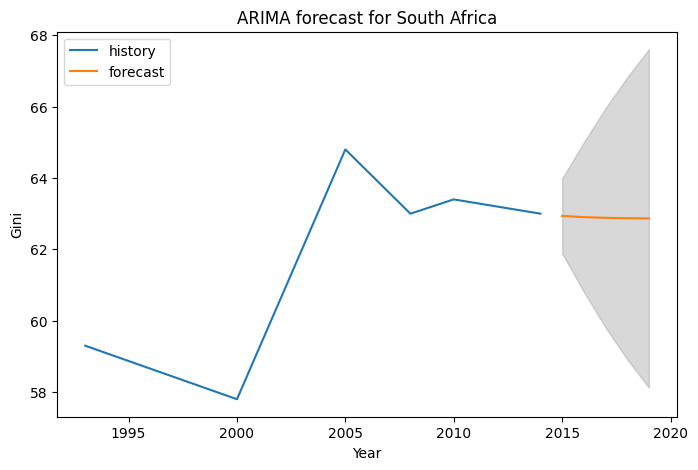

In [6]:
# Example country: choose one present in the dataset
country_example = 'South Africa' if 'South Africa' in data_model['country_name'].values else data_model['country_name'].unique()[0]

series = data_model[data_model['country_name'] == country_example].set_index('year').sort_index()['gini']
# Reindex to full range and interpolate
series = series.reindex(range(series.index.min(), series.index.max()+1)).interpolate().ffill().bfill()

plt.plot(series.index, series.values)
plt.title(f'Gini series — {country_example}')
plt.show()

# Fit ARIMA baseline (p,d,q) = (1,1,1)
p,d,q = 1,1,1
model = ARIMA(series, order=(p,d,q)).fit()
print(model.summary())

# Forecast
h = 5
forecast_res = model.get_forecast(steps=h)
forecast = forecast_res.predicted_mean
ci = forecast_res.conf_int()

# Plot
plt.figure(figsize=(8,5))
plt.plot(series.index, series.values, label='history')
fc_index = np.arange(series.index.max()+1, series.index.max()+1+h)
plt.plot(fc_index, forecast.values, label='forecast')
plt.fill_between(fc_index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3)
plt.legend(); plt.title(f'ARIMA forecast for {country_example}')
plt.xlabel('Year'); plt.ylabel('Gini')
plt.show()

## Cross-country ML model (excluding time feature)

Task: Predict `gini` using socioeconomic predictors for observations across countries and years, but **exclude `year`** from features — so the model learns cross-sectional relationships and differences across countries/periods.


Shapes: (124, 12) (31, 12)
RandomForest — MSE: 4.836, MAE: 1.442, R2: 0.952
Top features:
gdp_percap_const               0.431146
population                     0.257004
trade_pct_gdp                  0.103193
unemployment_pct               0.051839
edu_spend_pct_gdp              0.048706
inflation_pct                  0.047547
country_name_Germany           0.026551
country_name_China             0.010391
country_name_India             0.010116
country_name_United States     0.007603
country_name_United Kingdom    0.003226
country_name_South Africa      0.002678
dtype: float64


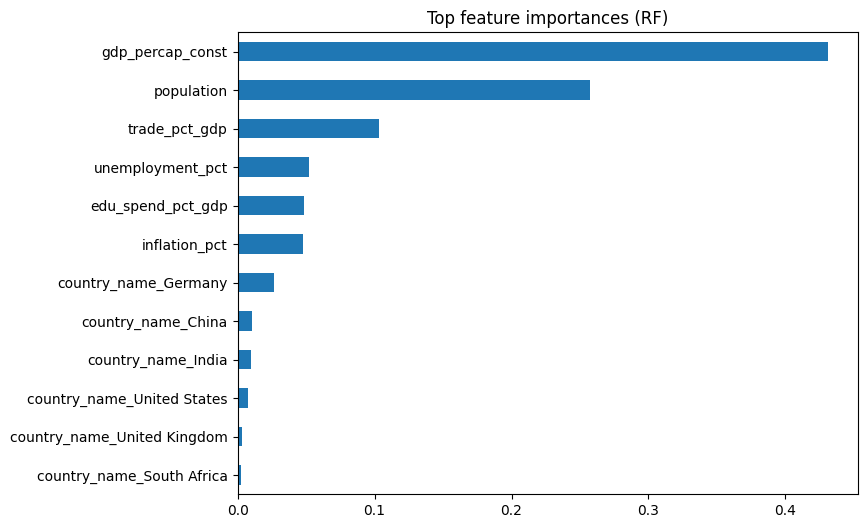

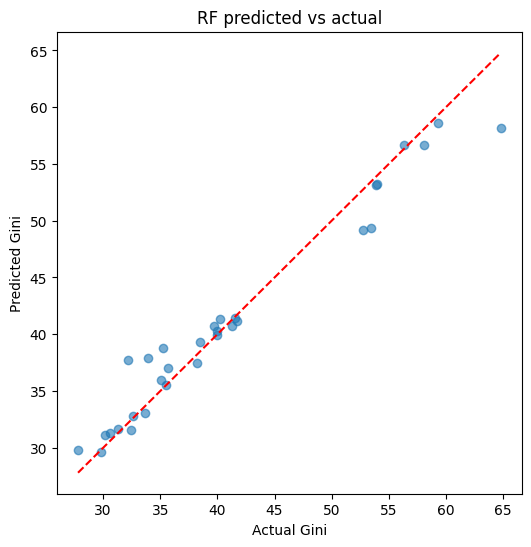

In [7]:
# Frame X and y
X = data_model[['country_name'] + predictors].copy()
y = data_model['gini'].copy()

# One-hot encode country_name
X = pd.get_dummies(X, columns=['country_name'], drop_first=True)

# Train/test split (random across observations)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric predictors
num_cols = predictors
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print('Shapes:', X_train.shape, X_test.shape)

# Random Forest baseline
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RandomForest — MSE: {mse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}')

# Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
print('Top features:')
print(feat_imp)

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top feature importances (RF)')
plt.show()

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Gini'); plt.ylabel('Predicted Gini'); plt.title('RF predicted vs actual')
plt.show()

## Conclusions & next steps

**Conclusions:**
- Time-series models (ARIMA) can provide short-term forecasts for countries with reasonably long and regular Gini observations. Interpret forecasts cautiously for long horizons.
- Cross-country models (RandomForest/XGBoost) can explain a portion of cross-sectional variation in Gini using socioeconomic predictors; feature importance highlights which variables are most predictive.

**Next steps / improvements:**
1. Expand dataset to include more countries and additional features (tax/transfer data, labor share, sectoral composition, political variables).
2. Use panel-data econometric models (fixed effects, random effects) to explicitly control for unobserved country-level heterogeneity.
3. Use more robust time-series pipelines: auto_arima, Prophet with changepoint handling, or Bayesian hierarchical time-series models to borrow strength across countries.
4. Perform better missing-data handling (multiple imputation) and sensitivity analysis.


---

### Appendix: Helpful code snippets

- How to save this notebook to GitHub Pages: export as HTML and push to `username.github.io` repository. Include this `.ipynb` and an `index.html` for static hosting.

- If you prefer a single combined CSV instead of using the World Bank API, download the WDI bulk CSV and merge on `Country Name` + `Year`.
